In [1]:
#                                       For pylance 
import tqdm                           # type: ignore
import numpy as np                    # type: ignore
from matplotlib import pyplot as plt  # type: ignore

from GIF_Saver import *               # type: ignore

In [2]:
# Lattice & Simulation setup 

Nx = 500
Ny = 250

N_steps   = 15000 
save_freq = 20

# Relaxation parameter related to kinematic viscosity
tau     = 0.65

# Cylinder obstacle parameters
x_cent, y_cent = Nx//5, Ny//2
radius         = Ny//8
X,Y            = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing = 'ij')
cylinder       = (X-x_cent)**2 + (Y-y_cent)**2 <= radius**2

# Inlet flow parameters
# * 
# Inlet velocity in lattice units
u_inlet = 0.12
i_inlet = 0
u_x = u_inlet
u_y = 0.0

print(f'Grid dimension:   ({Nx} x {Ny}) = {Nx*Ny} cells')
print(f'Frames to output: {N_steps // save_freq}')

Grid dimension:   (500 x 250) = 125000 cells
Frames to output: 750


In [3]:
# Arrays initialization

w   = np.array([4/9] + [1/9]*4 + [1/36]*4)          # D2Q9 Lattice model weights
u   = np.zeros((2, Nx, Ny))                         # Velocity vector field 
f   = np.zeros((9, Nx, Ny))                         # Flow distribution function
rho = np.ones((Nx, Ny))                             # Density scalar field
e   = np.array([[0,0],                              # Lattice Direction vectors
                [1,0],[0,1], [-1,0], [0,-1],
                [1,1],[-1,1],[-1,-1],[1,-1]])
opposite = [0, 3, 4, 1, 2, 7, 8, 5, 6]              # Opposite directions indicator for e

# Initializing F with equilibrium state
f = w[:, np.newaxis, np.newaxis] * rho[np.newaxis, :, :]

# Velocity field history list
u_hist = [  ]

In [4]:
# Simulation loop

for i_step in tqdm.tqdm(range(N_steps)):

    # 1. Updating density and velocity based on distribution function F
    rho  = np.sum(f, axis = 0)
    u[0] = np.sum(f * e[:, 0][:, np.newaxis, np.newaxis], axis = 0) / rho
    u[1] = np.sum(f * e[:, 1][:, np.newaxis, np.newaxis], axis = 0) / rho 


    # 2. Enforcing boundary conditions
    u[0, i_inlet, :] = u_x 
    u[1, i_inlet, :] = u_y 

    # Ensuring mass conservation
    rho[i_inlet, :] = (1 / (1 - u_x)) * (f[0, i_inlet, :] + f[2, i_inlet, :] + f[4, i_inlet, :] +2 * (f[3, i_inlet, :] + f[6, i_inlet, :] + f[7, i_inlet, :]))

    # Reconstructing flow distribution at boundary with Zou-He formula
    f[1, i_inlet, :] = f[3, i_inlet, :] + (2/3) * rho[i_inlet, :] * u_x
    f[5, i_inlet, :] = f[7, i_inlet, :] + (1/6) * rho[i_inlet, :] * (u_x + u_y)
    f[8, i_inlet, :] = f[6, i_inlet, :] + (1/6) * rho[i_inlet, :] * (u_x - u_y)

    # Cylinder No-slip boundary condition
    u[0] *= (1 - cylinder)
    u[1] *= (1 - cylinder)
    for i_dir in range(9):
        f[i_dir, cylinder] = f[opposite[i_dir], cylinder]

    # Zero-Gradient on outlet boundary
    i_outlet = Nx - 1
    f[:, i_outlet, :] = f[:, i_outlet - 1, :]

    
    # 3. Collision step 
    f_eq = np.zeros_like(f)
    u_sq = u[0]**2 + u[1]**2
    for i_dir in range(9):
        e_dot_u = e[i_dir,0]*u[0] + e[i_dir,1]*u[1]
        f_eq[i_dir] = w[i_dir]*rho*(1 + 3*e_dot_u + 9/2*e_dot_u**2 - 3/2*u_sq)

    f = f - 1/tau*(f - f_eq)


    # 4. Streaming step: propagating the effects along the grid
    for i_dir in range(9):
        f[i_dir] = np.roll(f[i_dir], shift = e[i_dir], axis = (0,1))
    
    # Removing periodicity effect (induced by "roll" operation) on the outlet boundary
    # NB: Left and Right boundaries are periodic.
    f[:, i_outlet, :] = f[:, i_outlet-1, :]


    # 5. Saving velocity frame if needed
    if (i_step % save_freq == 0):
        u_hist.append(u.copy())

100%|██████████| 15000/15000 [14:01<00:00, 17.83it/s]


In [7]:
# Some flow metrics
u_magnitude = [np.sqrt(u_[0]**2 + u_[1]**2) for u_ in u_hist]
u_vorticity = [np.gradient(u_[0], 1, axis=0) - np.gradient(u_[1], 1, axis=1) for u_ in u_hist]

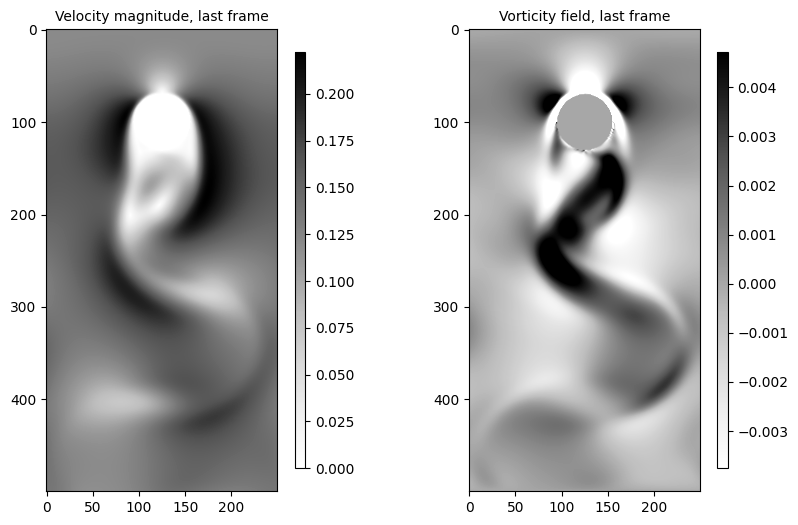

In [31]:
# Last frame state

fig, axes = plt.subplots(1,2, figsize = (10, 6))
pos0 = axes[0].imshow(u_magnitude[-1], cmap = 'Greys')
pos1 = axes[1].imshow(u_vorticity[-1], cmap = 'Greys', vmin = np.quantile(u_vorticity[-1], 0.02), vmax = np.quantile(u_vorticity[-1], 0.98))

axes[0].set_title('Velocity magnitude, last frame', fontsize = 10)
axes[1].set_title('Vorticity field, last frame', fontsize = 10)

fig.colorbar(pos0, aspect = 40, shrink = 0.9)
fig.colorbar(pos1, aspect = 40, shrink = 0.9)

plt.show()

In [32]:
# Saving animation

save_GIF(u_vorticity[::3], interval=45, cmap_ = 'Greys', output_file='animation_3.gif')